# Predict Sex

This notebook goes through a simple binary classification example, explaining general library functionality along the way.
Within this notebook we make use of data downloaded from Release 2.0.1 of the the ABCD Study (https://abcdstudy.org/).
This dataset is openly available to researchers (after signing a data use agreement) and is particularly well suited
towards performing neuroimaging based ML given the large sample size of the study.

Within this notebook we will be performing binary classification predicting sex assigned at birth from tabular ROI structural MRI data.

## Load Data

In [1]:
import BPt as bp
import pandas as pd
import os

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
def load_from_rds(names, eventname='baseline_year_1_arm_1'):
    
    data = pd.read_csv('data/nda_rds_201.csv',
                       usecols=['src_subject_id', 'eventname'] + names,
                       na_values=['777', 999, '999', 777])
    
    data = data.loc[data[data['eventname'] == eventname].index]
    data = data.set_index('src_subject_id')
    data = data.drop('eventname', axis=1)
    
    # Obsificate subject ID for public example
    data.index = list(range(len(data)))
    
    # Return as pandas DataFrame cast to BPt Dataset
    return bp.Dataset(data)

In [3]:
# This way we can look at all column avaliable
all_cols = list(pd.read_csv('data/nda_rds_201.csv', nrows=0))

We can search through all column to find which columns we actually want to load. We will start with the brain imaging features.

In [4]:
feat_keys = {'thick': 'smri_thick_cort.destrieux_g.',
             'sulc': 'smri_sulc_cort.destrieux_g.',
             'area': 'smri_area_cort.destrieux_g.',
             'subcort': 'smri_vol_subcort.aseg_'}

feat_cols = {key: [c for c in all_cols if feat_keys[key] in c] for key in feat_keys}
all_cols = sum(feat_cols.values(), [])

# For example
feat_cols['thick'][:10]

['smri_thick_cort.destrieux_g.and.s.frontomargin.lh',
 'smri_thick_cort.destrieux_g.and.s.occipital.inf.lh',
 'smri_thick_cort.destrieux_g.and.s.paracentral.lh',
 'smri_thick_cort.destrieux_g.and.s.subcentral.lh',
 'smri_thick_cort.destrieux_g.and.s.transv.frontopol.lh',
 'smri_thick_cort.destrieux_g.and.s.cingul.ant.lh',
 'smri_thick_cort.destrieux_g.and.s.cingul.mid.ant.lh',
 'smri_thick_cort.destrieux_g.and.s.cingul.mid.post.lh',
 'smri_thick_cort.destrieux_g.cingul.post.dorsal.lh',
 'smri_thick_cort.destrieux_g.cingul.post.ventral.lh']

We also need our target variable, in this case sex.

Let's load household income too as a non input, i.e., a variable we won't use directly as input.

In [5]:
target = 'sex'
non_inputs = ['household.income']

In [6]:
data = load_from_rds(all_cols + [target] + non_inputs )
data.verbose = 1
data

/home/sage/anaconda3/envs/bpt/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (63641) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,household.income,sex,smri_area_cort.destrieux_g.and.s.cingul.ant.lh,smri_area_cort.destrieux_g.and.s.cingul.ant.rh,smri_area_cort.destrieux_g.and.s.cingul.mid.ant.lh,smri_area_cort.destrieux_g.and.s.cingul.mid.ant.rh,smri_area_cort.destrieux_g.and.s.cingul.mid.post.lh,smri_area_cort.destrieux_g.and.s.cingul.mid.post.rh,smri_area_cort.destrieux_g.and.s.frontomargin.lh,smri_area_cort.destrieux_g.and.s.frontomargin.rh,...,smri_vol_subcort.aseg_subcorticalgrayvolume,smri_vol_subcort.aseg_supratentorialvolume,smri_vol_subcort.aseg_thalamus.proper.lh,smri_vol_subcort.aseg_thalamus.proper.rh,smri_vol_subcort.aseg_ventraldc.lh,smri_vol_subcort.aseg_ventraldc.rh,smri_vol_subcort.aseg_wholebrain,smri_vol_subcort.aseg_wm.hypointensities,smri_vol_subcort.aseg_wm.hypointensities.lh,smri_vol_subcort.aseg_wm.hypointensities.rh
0,[>=50K & <100K],F,1540.0,1921.0,1237.0,1211.0,939.0,1022.0,872.0,596.0,...,54112.0,9.738411e+05,6980.4,6806.6,3448.1,3372.7,1.099494e+06,2201.9,0.0,0.0
1,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[>=100K],M,2108.0,2583.0,1289.0,1295.0,1066.0,1328.0,907.0,843.0,...,71188.0,1.290405e+06,9091.3,8105.3,5058.5,5261.6,1.444690e+06,1254.8,0.0,0.0
3,[>=100K],M,2196.0,2266.0,1012.0,1459.0,1326.0,1398.0,944.0,924.0,...,61985.0,1.283405e+06,7470.7,7278.4,3924.8,3983.6,1.421171e+06,950.9,0.0,0.0
4,[<50K],M,1732.0,1936.0,1024.0,916.0,900.0,1002.0,863.0,730.0,...,61855.0,1.072113e+06,8152.9,7436.8,4085.2,4129.3,1.186497e+06,789.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11870,[>=100K],M,1583.0,1821.0,730.0,1040.0,709.0,872.0,938.0,745.0,...,59550.0,1.001272e+06,7993.5,7239.5,3899.4,4024.6,1.139532e+06,651.7,0.0,0.0
11871,[>=100K],F,1603.0,1841.0,899.0,1091.0,990.0,995.0,809.0,666.0,...,61090.0,9.897016e+05,7113.5,6835.3,4029.6,3826.0,1.134203e+06,2304.8,0.0,0.0
11872,[>=100K],F,1862.0,2245.0,1406.0,1502.0,882.0,1279.0,1105.0,1015.0,...,64413.0,1.172208e+06,8123.0,7947.6,3893.0,4428.5,1.301402e+06,1654.0,0.0,0.0
11873,[<50K],F,1803.0,1888.0,967.0,1101.0,866.0,1128.0,1040.0,642.0,...,55505.0,1.040864e+06,6923.8,6459.8,3502.5,3674.0,1.150473e+06,1209.5,0.0,0.0


Next we need to tell the dataset a few things about sex, namely that it is a binary variable, and that it is our target variable.

In [7]:
data.to_binary('sex', inplace=True)
data.set_target('sex', inplace=True)
data['target']

,sex
0,0
1,0
2,1
3,1
4,1
...,...
11870,1
11871,0
11872,0
11873,0


We need to do something simillar for household income, tell it that it is a categorical variable, and has role non input

In [8]:
data = data.ordinalize('household.income').set_role('household.income', 'non input')

Dropped 1018 Rows


Let's look at some NaN info

In [9]:
data.nan_info()

Loaded NaN Info:
There are: 83896 total missing values
224 columns found with 304 missing values (column name overlap: ['cort.', 'smri_'])
9 columns found with 305 missing values (column name overlap: ['cort.', 'smri_'])
3 columns found with 408 missing values (column name overlap: ['smri_vol_subcort.aseg_', 'le'])
3 columns found with 349 missing values (column name overlap: ['smri_area_cort.destrieux_g.', 'ar', 'd.'])
3 columns found with 306 missing values (column name overlap: ['smri_area_cort.destrieux_g.'])
2 columns found with 340 missing values (column name overlap: ['smri_area_cort.destrieux_g.', '.lh', '.s', 'an', 'l.'])
2 columns found with 324 missing values (column name overlap: ['smri_area_cort.destrieux_g.and.s.cingul.mid.', 't.rh'])
2 columns found with 314 missing values (column name overlap: ['smri_area_cort.destrieux_g.', 'temp.', '.lat'])
2 columns found with 309 missing values (column name overlap: ['smri_vol_subcort.aseg_c'])
2 columns found with 307 missing value

What happens now if we drop any subjects with more than 1% of their loaded columns with NaN values

In [10]:
data = data.drop_subjects_by_nan(threshold=.01)
data.nan_info()

Setting NaN threshold to: 2.74
Dropped 408 Rows
Loaded NaN Info:
There are: 885 total missing values
9 columns found with 1 missing values (column name overlap: ['cort.', 'smri_'])
3 columns found with 2 missing values (column name overlap: ['smri_area_cort.destrieux_g.'])
3 columns found with 38 missing values (column name overlap: ['smri_area_cort.destrieux_g.'])
3 columns found with 3 missing values (column name overlap: [])
3 columns found with 45 missing values (column name overlap: ['smri_area_cort.destrieux_g.', 'ar', 'd.'])
2 columns found with 43 missing values (column name overlap: ['smri_area_cort.destrieux_g.', '.rh', 'ar', 'nt', 'er'])
2 columns found with 41 missing values (column name overlap: ['smri_area_cort.destrieux_g.', 'ngul.', 't.'])
2 columns found with 35 missing values (column name overlap: ['smri_area_cort.destrieux_g.', '.lh', '.s', 'an'])
2 columns found with 5 missing values (column name overlap: ['smri_vol_subcort.aseg_c'])
2 columns found with 10 missing 

That greatly reduces the number of remaining missing values we have. Next, let's consider outlier filtering as...

In [11]:
data.skew().sort_values()

smri_thick_cort.destrieux_g.front.middle.rh          -1.492846
smri_thick_cort.destrieux_g.temporal.middle.lh       -1.311317
smri_thick_cort.destrieux_g.pariet.inf.angular.rh    -1.284709
smri_thick_cort.destrieux_g.precentral.rh            -1.269309
smri_thick_cort.destrieux_g.temporal.middle.rh       -1.238609
                                                       ...    
smri_vol_subcort.aseg_latventricles                   4.022606
smri_vol_subcort.aseg_lateral.ventricle.rh            4.504116
smri_area_cort.destrieux_g.cingul.post.ventral.lh     5.093452
smri_area_cort.destrieux_g.cingul.post.ventral.rh     5.106974
smri_vol_subcort.aseg_wm.hypointensities             16.605102
Length: 272, dtype: float64

In [12]:
# We don't even care about these measurements
data = data.drop_cols(exclusions='aseg_wm.hypointensities')

Dropped 3 Columns


In [13]:
data = data.filter_outliers_by_std(n_std=10)

Dropped 53 Rows


sex: 10393 rows (3 NaN)


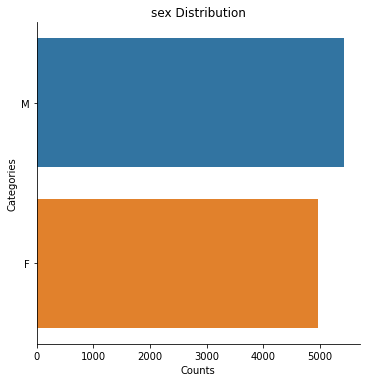

In [14]:
data.plot('target')

Note we have some missing data in the target variable, we can drop these.

In [15]:
data = data.drop_nan_subjects('target')

Dropped 3 Rows


Let's lastly split our data in a train test split.

In [16]:
train_data, test_data = data.test_split(size=.2, random_state=2)
train_data

Performing test split on: 10393 subjects.
random_state: 2
Test split size: 0.2

Performed train/test split
Train size: 8314
Test size:  2079


,smri_area_cort.destrieux_g.and.s.cingul.ant.lh,smri_area_cort.destrieux_g.and.s.cingul.ant.rh,smri_area_cort.destrieux_g.and.s.cingul.mid.ant.lh,smri_area_cort.destrieux_g.and.s.cingul.mid.ant.rh,smri_area_cort.destrieux_g.and.s.cingul.mid.post.lh,smri_area_cort.destrieux_g.and.s.cingul.mid.post.rh,smri_area_cort.destrieux_g.and.s.frontomargin.lh,smri_area_cort.destrieux_g.and.s.frontomargin.rh,smri_area_cort.destrieux_g.and.s.occipital.inf.lh,smri_area_cort.destrieux_g.and.s.occipital.inf.rh,...,smri_vol_subcort.aseg_pallidum.rh,smri_vol_subcort.aseg_putamen.lh,smri_vol_subcort.aseg_putamen.rh,smri_vol_subcort.aseg_subcorticalgrayvolume,smri_vol_subcort.aseg_supratentorialvolume,smri_vol_subcort.aseg_thalamus.proper.lh,smri_vol_subcort.aseg_thalamus.proper.rh,smri_vol_subcort.aseg_ventraldc.lh,smri_vol_subcort.aseg_ventraldc.rh,smri_vol_subcort.aseg_wholebrain
0,1540.0,1921.0,1237.0,1211.0,939.0,1022.0,872.0,596.0,820.0,839.0,...,1392.5,5471.6,5002.9,54112.0,9.738411e+05,6980.4,6806.6,3448.1,3372.7,1.099494e+06
2,2108.0,2583.0,1289.0,1295.0,1066.0,1328.0,907.0,843.0,1571.0,1056.0,...,2102.4,6520.7,6929.8,71188.0,1.290405e+06,9091.3,8105.3,5058.5,5261.6,1.444690e+06
3,2196.0,2266.0,1012.0,1459.0,1326.0,1398.0,944.0,924.0,1209.0,1159.0,...,2030.0,6521.7,5647.1,61985.0,1.283405e+06,7470.7,7278.4,3924.8,3983.6,1.421171e+06
6,1537.0,1986.0,1151.0,1178.0,1182.0,1389.0,839.0,678.0,1250.0,1207.0,...,1859.0,6599.7,6317.0,65182.0,1.135326e+06,8437.8,8259.8,3734.3,4159.9,1.263524e+06
7,1824.0,2095.0,893.0,1066.0,1067.0,1046.0,974.0,828.0,890.0,963.0,...,1456.7,5929.8,5642.2,60637.0,1.096084e+06,7891.9,7439.4,3945.9,3831.0,1.218476e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11870,1583.0,1821.0,730.0,1040.0,709.0,872.0,938.0,745.0,789.0,825.0,...,1610.9,6090.9,5444.8,59550.0,1.001272e+06,7993.5,7239.5,3899.4,4024.6,1.139532e+06
11871,1603.0,1841.0,899.0,1091.0,990.0,995.0,809.0,666.0,1155.0,844.0,...,1664.6,7042.9,6654.0,61090.0,9.897016e+05,7113.5,6835.3,4029.6,3826.0,1.134203e+06
11872,1862.0,2245.0,1406.0,1502.0,882.0,1279.0,1105.0,1015.0,1256.0,960.0,...,1856.8,6331.3,6366.1,64413.0,1.172208e+06,8123.0,7947.6,3893.0,4428.5,1.301402e+06
11873,1803.0,1888.0,967.0,1101.0,866.0,1128.0,1040.0,642.0,939.0,892.0,...,1470.9,5730.4,5469.3,55505.0,1.040864e+06,6923.8,6459.8,3502.5,3674.0,1.150473e+06


## Evaluating Models

We will start by evaluating some different choices of pipelines / models on just our training data

In [17]:
ps = bp.ProblemSpec(scorer=['roc_auc'],
                    n_jobs=16)
ps

ProblemSpec(n_jobs=16, scorer=['roc_auc'])

In [18]:
model_pipeline = bp.ModelPipeline(model=bp.Model('dt'))
model_pipeline.print_all()

ModelPipeline
-------------
imputers=\
Imputer(obj='default')

scalers=\
Scaler(obj='standard')

model=\
Model(obj='dt')

param_search=\
None



We can see that the their are a few default values, specifically we have a set of default imputers, one for replacing all float variables with the mean value, and one for replacing all categorical / binary variables (if any, otherwise ignored) with the median values.

Next, we have a just standard scaler, which scales all features to have mean 0, std of 1.

Then, we have our decision tree.

Lastly, we have no param_search specified.

Now that we have an initial model, we are ready to use the Evaluate function

In [19]:
results = bp.evaluate(pipeline=model_pipeline,
                      dataset=train_data,
                      problem_spec=ps,
                      cv=5)

results

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'roc_auc': 0.652643152409617}
std_scores = {'roc_auc': 0.0032142396653817864}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'feature_importances_']

Avaliable Methods: ['get_X_transform_df', 'get_preds_dfs', 'get_fis', 'get_feature_importances', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=16, problem_type='binary',
            scorer={'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)},
            subjects='all', target='sex')

Let's try a just linear model now (Logistic Regression, since binary), updating our model within our model_pipeline first.

In [20]:
model_pipeline.model = bp.Model('linear')

results = bp.evaluate(pipeline=model_pipeline,
                      dataset=train_data,
                      problem_spec=ps,
                      cv=5)

results

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'roc_auc': 0.904121897548382}
std_scores = {'roc_auc': 0.006991688270369848}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_X_transform_df', 'get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=16, problem_type='binary',
            scorer={'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)},
            subjects='all', target='sex')

## Examing Evaluation Results

The returned BPtEvaluator, which we store in variable results, has a bunch of different extra functionality built in for further examining the results of the evaluation. We will explore some of those functions here.

We can look fisrt at for example the raw predictions made:

In [21]:
preds = results.get_preds_dfs()

# Just first fold
preds[0]

,predict,predict_proba_0,predict_proba_1,decision_function,y_true
0,0.0,0.936433,0.063567,-2.689987,0.0
3,1.0,0.044796,0.955204,3.059801,1.0
6,1.0,0.114142,0.885858,2.049114,1.0
7,1.0,0.122291,0.877709,1.970911,1.0
15,1.0,0.025838,0.974162,3.629715,1.0
...,...,...,...,...,...
11837,1.0,0.412130,0.587870,0.355167,1.0
11841,0.0,0.853139,0.146861,-1.759439,1.0
11849,1.0,0.484163,0.515837,0.063370,0.0
11857,0.0,0.988427,0.011573,-4.447442,0.0


Sometimes it can be useful to look at predictions made as resitricted to only a group of subjects. Here's where we can use that household income information.

In [22]:
# See how these values are coded
train_data.encoders['household.income']

{0: '[<50K]', 1: '[>=100K]', 2: '[>=50K & <100K]'}

In [23]:
# First we want to get just the subset of subjects
# from let's say the first fold and just under 50K
fold_preds = preds[0]
val_subjs = fold_preds.index
vs = bp.ValueSubset('household.income', '[<50K]', decode_values=True)

# Specify the intersection of those subsets of subjects
subjs = bp.Intersection([val_subjs, vs])

# Get the specific subject values
subset_subjects = train_data.get_subjects(subjs)
subset_preds = fold_preds.loc[subset_subjects]

subset_preds

,predict,predict_proba_0,predict_proba_1,decision_function,y_true
2049,1.0,0.051997,0.948003,2.903164,1.0
6,1.0,0.114142,0.885858,2.049114,1.0
7,1.0,0.122291,0.877709,1.970911,1.0
6154,0.0,0.939120,0.060880,-2.736043,0.0
10251,1.0,0.011423,0.988577,4.460610,1.0
...,...,...,...,...,...
8171,1.0,0.020307,0.979693,3.876290,1.0
2032,0.0,0.979160,0.020840,-3.849802,0.0
4082,1.0,0.026987,0.973013,3.585060,1.0
4089,1.0,0.042656,0.957344,3.111002,1.0


Now let's say we want to look at roc auc on just this subset

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(subset_preds['y_true'], subset_preds['predict_proba_1'])

0.8824987132808478

One thing to note about post-stratify predictions by a group is that it is just a diagnostic tool. For example if we found that a sub group did much worse, it lets us know about the problem, but doesn't address it.

That said, the above code may be useful for getting more famillar with the different internal saved attributes of the BPtEvaluator, but is it the easiest way to get this breakdown? No. Actually their is a dedicated function to breaking down results by a subset, let's check it out.

In [25]:
subsets = results.subset_by(group='household.income', dataset=train_data)
list(subsets)

['[>=50K & <100K]', '[>=100K]', '[<50K]']

In [26]:
subsets['[<50K]']

BPtEvaluatorSubset(household.income=[<50K])
------------
mean_scores = {'roc_auc': 0.8927459075402938}
std_scores = {'roc_auc': 0.01241167653252817}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_X_transform_df', 'get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=16, problem_type='binary',
            scorer={'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)},
            subjects='all', target='sex')

Each of these objects can be treated the same as the main BPtEvaluator object, except with essentially a subset of validation subjects. I.e., let's look at the roc_auc we calculated vs. the saved one here for fold 0.

In [27]:
subsets['[<50K]'].scores['roc_auc'][0]

0.8824987132808478

What if we wanted to say plot a confusion matrix? Well it seems like scikit-learn has a method dedicated to that, let's see if we can use it.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

So for this function we need a trained estimator and then the validation X and y, let's grab those for just the first fold.

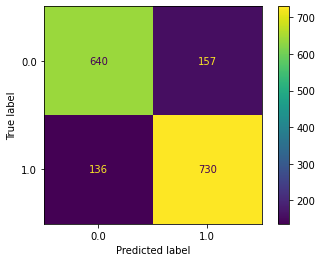

In [28]:
from sklearn.metrics import plot_confusion_matrix

fold = 0

estimator = results.estimators[fold]

X, y = train_data.get_Xy(ps=results.ps,
                         subjects=results.val_subjects[fold])

plot_confusion_matrix(estimator, X, y)

How would this change if we wanted to just plot the confusion matrix for that subset of subjects we looked at before? We just need to specify a different set of subjects, which we already calculated, so...

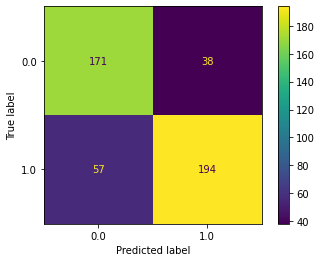

In [29]:
X, y = train_data.get_Xy(ps=results.ps,
                         subjects=subjs)

plot_confusion_matrix(estimator, X, y)

Or of course we could just the the Subset evaluator.

We can also look at feature importances as averaged across all 5 folds.

In [30]:
results.get_fis(mean=True).sort_values()

smri_vol_subcort.aseg_caudate.rh                   -0.491889
smri_vol_subcort.aseg_thalamus.proper.lh           -0.469694
smri_thick_cort.destrieux_g.postcentral.rh         -0.393656
smri_vol_subcort.aseg_cerebellum.white.matter.rh   -0.352483
smri_area_cort.destrieux_g.temp.sup.lateral.rh     -0.345213
                                                      ...   
smri_vol_subcort.aseg_putamen.rh                    0.328204
smri_vol_subcort.aseg_thalamus.proper.rh            0.364399
smri_vol_subcort.aseg_cerebellum.cortex.rh          0.442560
smri_vol_subcort.aseg_intracranialvolume            0.688781
smri_vol_subcort.aseg_cerebral.white.matter.rh      0.703118
Length: 269, dtype: float64

## LinearResidualizer

What we find here is a bit trivial. Basically just boys have bigger brains than girls ... That said, this is just an example. What if we say residualize in a nested way for intracranial volume?


In [31]:
from BPt.extensions import LinearResidualizer

resid = LinearResidualizer(to_resid_df=data[['smri_vol_subcort.aseg_intracranialvolume']])
resid_scaler = bp.Scaler(resid, scope='float')


resid_pipeline = bp.ModelPipeline(scalers=[bp.Scaler('robust'), resid_scaler],
                                  model=bp.Model('linear'))   

resid_pipeline.print_all()

ModelPipeline
-------------
imputers=\
Imputer(obj='default')

scalers=\
[Scaler(obj='robust'),
 Scaler(obj=LinearResidualizer(to_resid_df=       smri_vol_subcort.aseg_intracranialvolume
0                                  1.354788e+06
2                                  1.703982e+06
3                                  1.679526e+06
4                                  1.561216e+06
6                                  1.514361e+06
...                                         ...
11870                              1.480336e+06
11871                              1.470497e+06
11872                              1.455727e+06
11873                              1.480286e+06
11874                              1.500072e+06

[10393 rows x 1 columns]))]

model=\
Model(obj='linear')

param_search=\
None



In [32]:
results = bp.evaluate(pipeline=model_pipeline,
                      dataset=train_data,
                      problem_spec=ps,
                      cv=5)

results

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'roc_auc': 0.904121897548382}
std_scores = {'roc_auc': 0.006991688270369848}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_X_transform_df', 'get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=16, problem_type='binary',
            scorer={'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)},
            subjects='all', target='sex')

In [33]:
results.get_fis(mean=True).sort_values()

smri_vol_subcort.aseg_caudate.rh                   -0.491889
smri_vol_subcort.aseg_thalamus.proper.lh           -0.469694
smri_thick_cort.destrieux_g.postcentral.rh         -0.393656
smri_vol_subcort.aseg_cerebellum.white.matter.rh   -0.352483
smri_area_cort.destrieux_g.temp.sup.lateral.rh     -0.345213
                                                      ...   
smri_vol_subcort.aseg_putamen.rh                    0.328204
smri_vol_subcort.aseg_thalamus.proper.rh            0.364399
smri_vol_subcort.aseg_cerebellum.cortex.rh          0.442560
smri_vol_subcort.aseg_intracranialvolume            0.688781
smri_vol_subcort.aseg_cerebral.white.matter.rh      0.703118
Length: 269, dtype: float64

Notably residualizing is far from perfect..., it is interesting though how the results change when we add the residualization. 

## Default Pipelines


We can just ignore the issue for now, and explore some different pipelines (not residualizing anymore). We are going to just try some off the shelf default pipelines for simplicity.

In [34]:
from BPt.default.pipelines import pipelines

# Look at choices
print(list(pipelines))

# Look at the pipeline
pipelines['elastic_pipe']

['elastic_pipe', 'ridge_pipe', 'lgbm_pipe', 'svm_pipe', 'stacking_pipe', 'compare_pipe']


Pipeline(steps=[Imputer(obj='mean', scope='float'),
                Imputer(obj='median', scope='category'), Scaler(obj='robust'),
                Transformer(obj='one hot encoder', scope='category'),
                Model(obj='elastic',
                      param_search=ParamSearch(cv=CV(cv_strategy=CVStrategy()),
                                               n_iter=60),
                      params=1)])

In [35]:
results = bp.evaluate(pipeline=pipelines['elastic_pipe'],
                      dataset=train_data,
                      problem_spec=ps,
                      cv=5)
results

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'roc_auc': 0.9050843516449291}
std_scores = {'roc_auc': 0.006520964845338212}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_X_transform_df', 'get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=16, problem_type='binary',
            scorer={'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)},
            subjects='all', target='sex')

In [36]:
# Look at the pipeline
pipelines['lgbm_pipe']

Pipeline(steps=[Imputer(obj='mean', scope='float'),
                Imputer(obj='median', scope='category'), Scaler(obj='robust'),
                Transformer(obj='one hot encoder', scope='category'),
                Model(obj='lgbm',
                      param_search=ParamSearch(cv=CV(cv_strategy=CVStrategy()),
                                               n_iter=60),
                      params=1)])

In [37]:
results = bp.evaluate(pipeline=pipelines['lgbm_pipe'],
                      dataset=train_data,
                      problem_spec=ps,
                      scorer=['roc_auc', 'balanced_accuracy'],
                      cv=5)
results

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'roc_auc': 0.8810651333645121, 'balanced_accuracy': 0.8031876349839246}
std_scores = {'roc_auc': 0.010968292470025738, 'balanced_accuracy': 0.011458887286564062}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'feature_importances_']

Avaliable Methods: ['get_X_transform_df', 'get_preds_dfs', 'get_fis', 'get_feature_importances', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=16, problem_type='binary',
            scorer={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                    'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)},
            subjects='all', target='sex')

## Employ Test Set

How about now applying the test set, which can give us another estimate of generalizibility. One good strategy is re-train one model on the full training set, then we can apply it to the testing set, using say the elastic net based model.

In [38]:
from sklearn.metrics import roc_auc_score

# Get as a sklearn-style estimator
estimator = pipelines['elastic_pipe'].build(train_data, ps)

# Get train data
X_train, y_train = train_data.get_Xy(ps)

# Fit on train data
estimator.fit(X_train, y_train)

# Get test data
X_test, y_test = test_data.get_Xy(ps)

# Get test predictions
test_preds = estimator.predict_proba(X_test)

# Get roc_auc_score
roc_auc_score(y_test, test_preds[:, 1])

0.906483521992028